Extracting features (30s segments)...
 Processing blues...
 Processing classical...
 Processing country...
 Processing disco...
 Processing hiphop...
 Processing jazz...
Error processing C:\Users\Jacky\Documents\Machine_learnig_2025\genres_original\jazz\jazz.00054.wav: 
 Processing metal...
 Processing pop...
 Processing reggae...
 Processing rock...


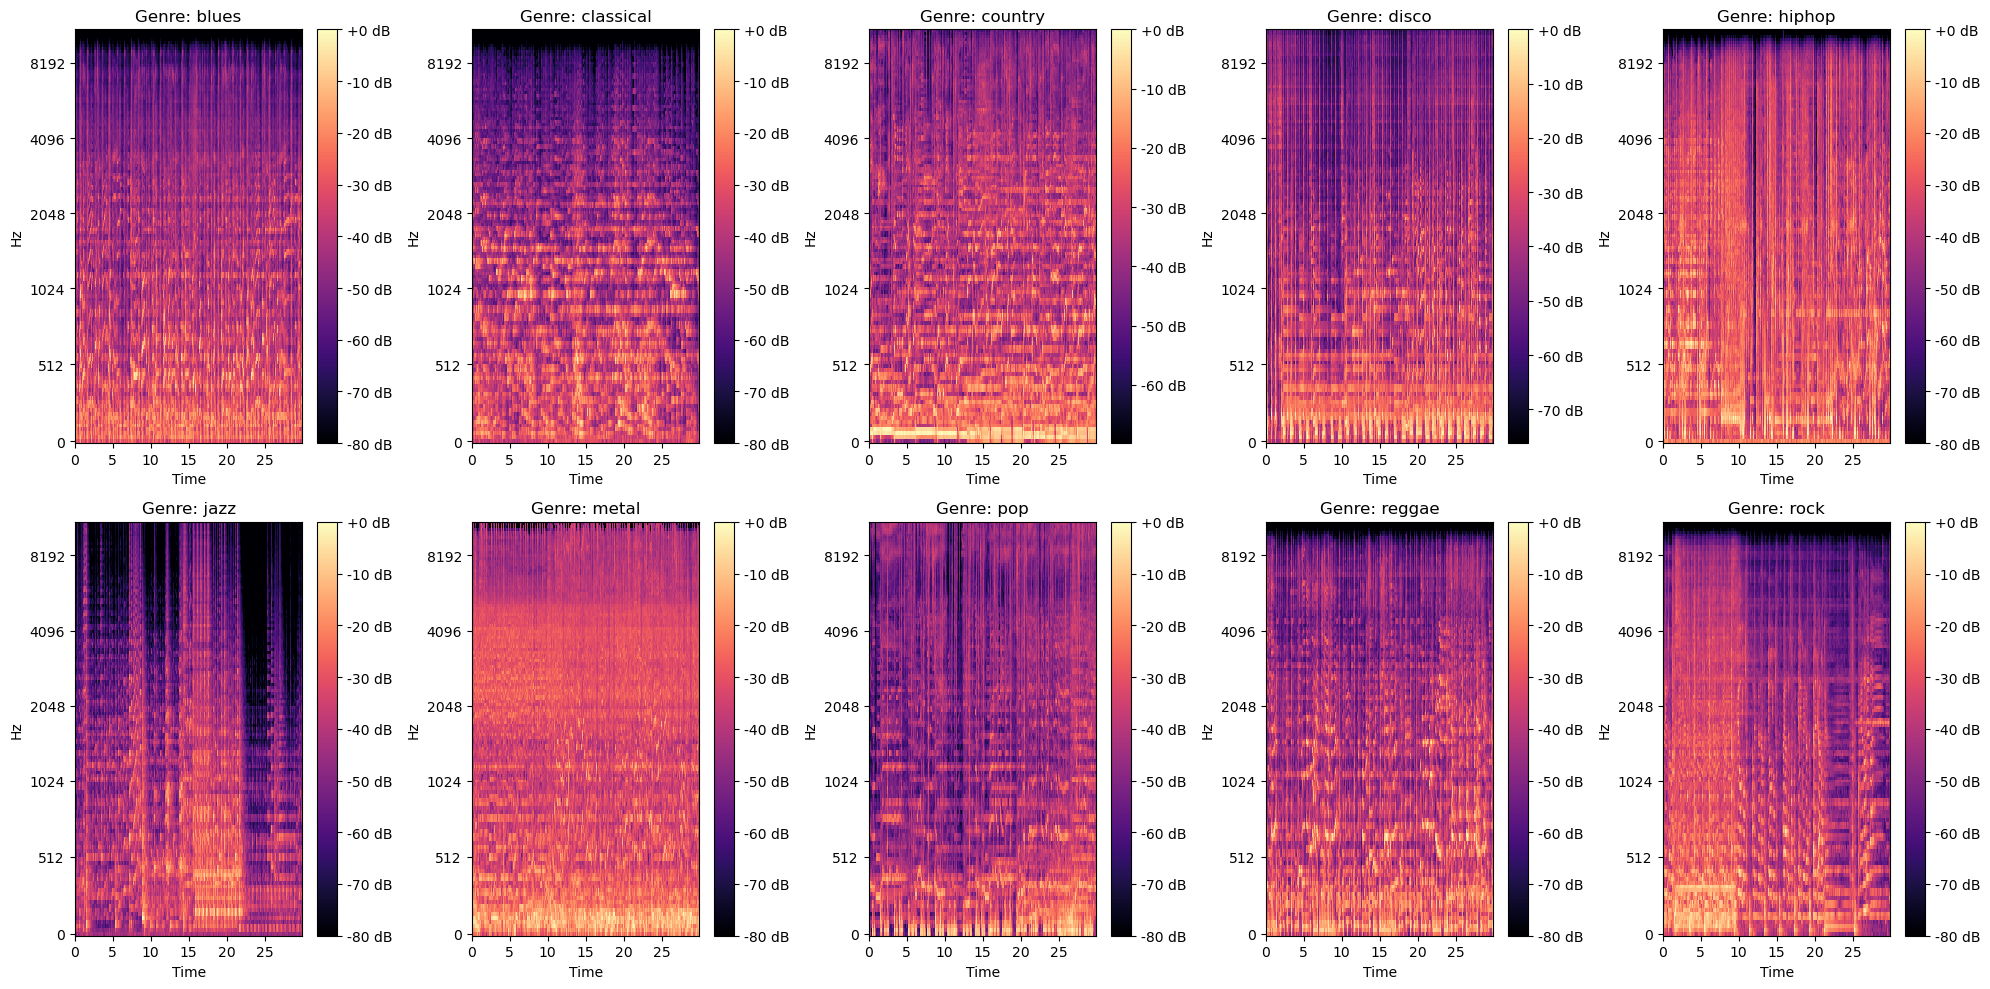


--- Training Baseline ---
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.1790 - loss: 2.6325 - val_accuracy: 0.2300 - val_loss: 2.0878
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3579 - loss: 1.7265 - val_accuracy: 0.4700 - val_loss: 1.5659
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5056 - loss: 1.4152 - val_accuracy: 0.4400 - val_loss: 1.4999
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6308 - loss: 1.0519 - val_accuracy: 0.5000 - val_loss: 1.4382
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7234 - loss: 0.8020 - val_accuracy: 0.4600 - val_loss: 1.4868
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8448 - loss: 0.4727 - val_accuracy: 0.5200 - val_loss: 1.7009
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9274 - loss: 0.2138 - val_accuracy: 0.5200 - val_loss: 1.8547
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9149 - loss: 0.2546 - val_a

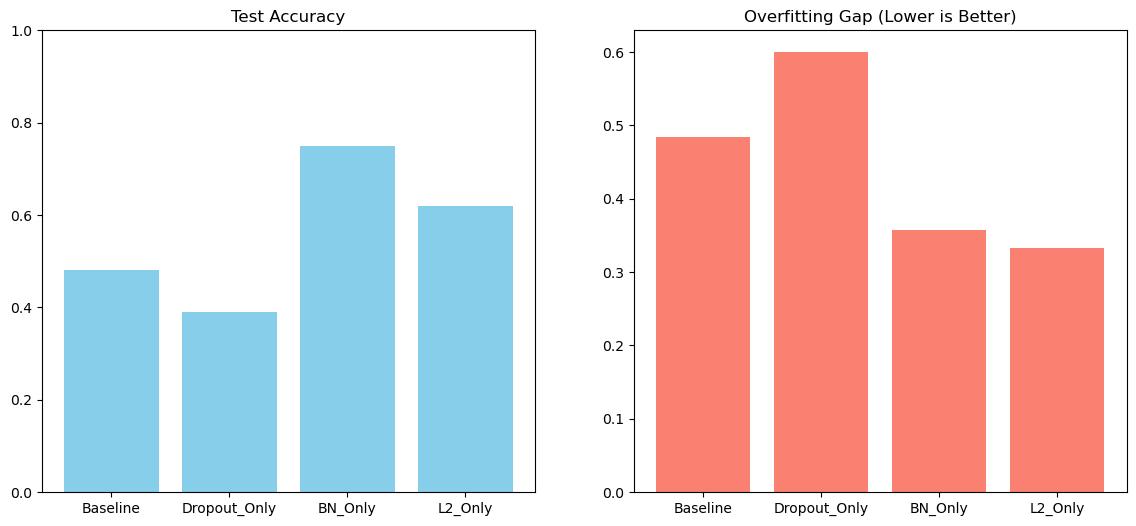

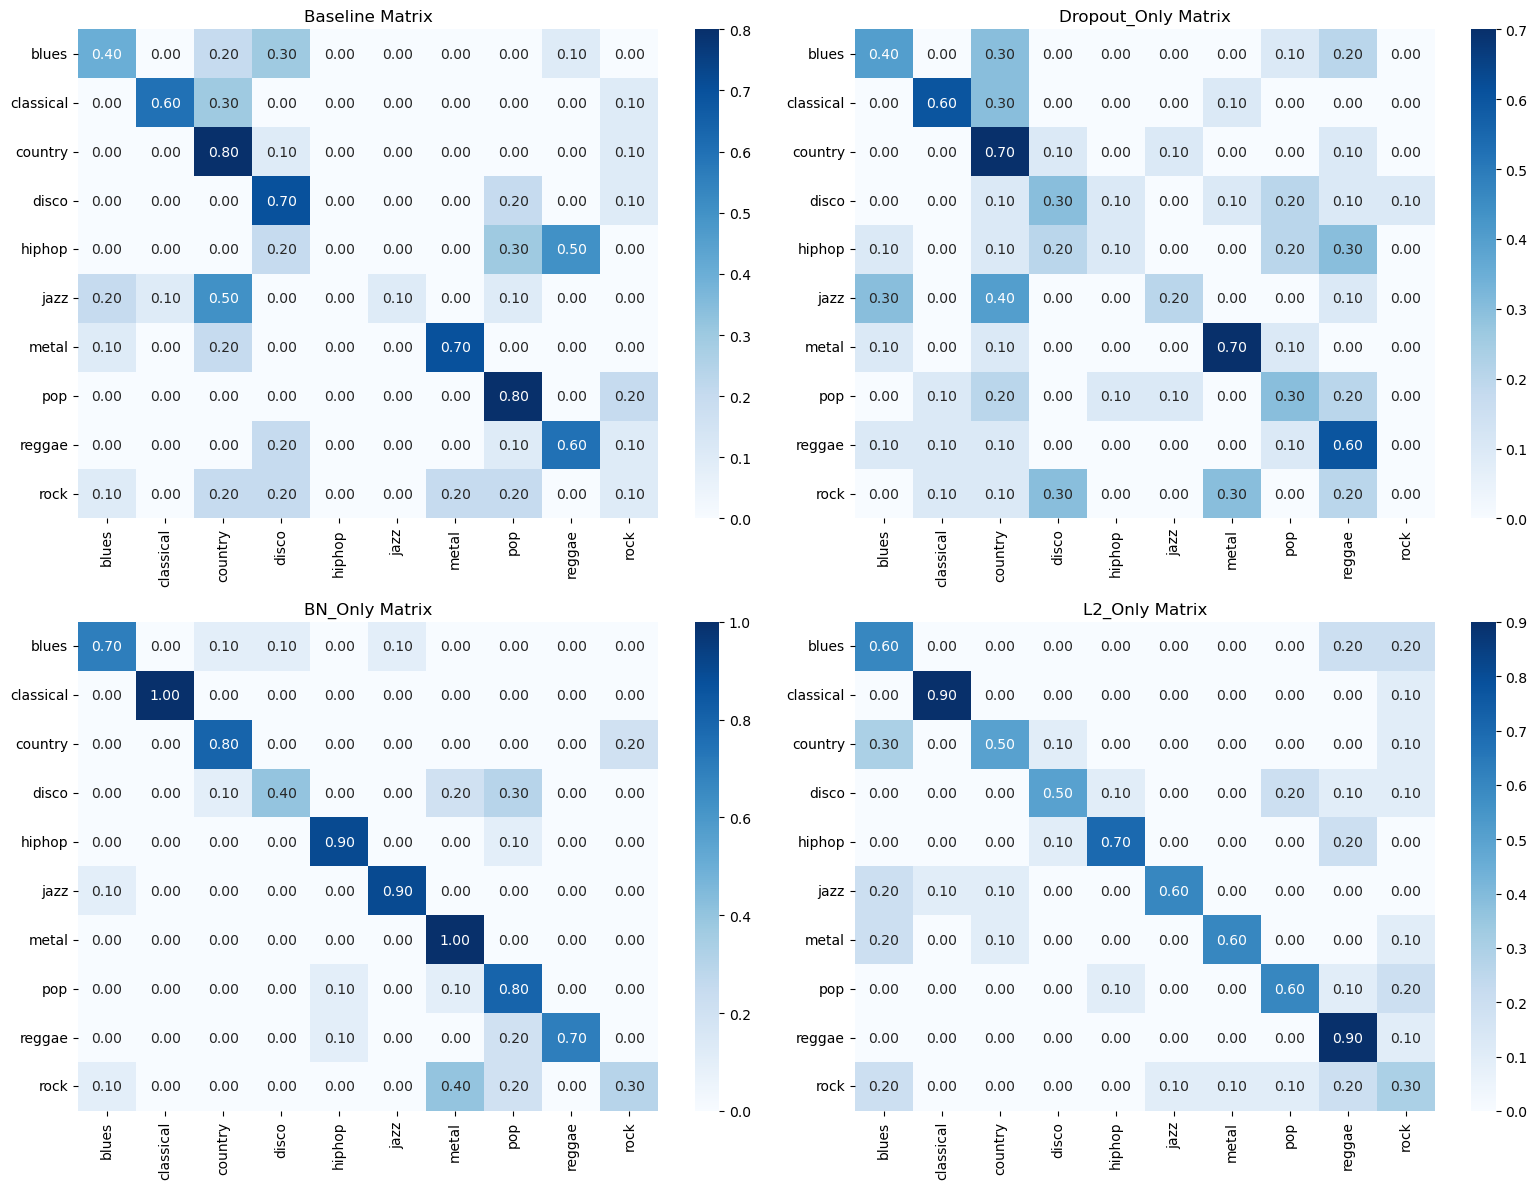


                                REGULARIZATION STRATEGY SUMMARY                                
             Train Acc Val Acc Test Acc Gap (Overfit) Gen. Ratio   Parameters
Baseline        0.9837  0.5000   0.4800        0.4837     0.4879 42,333,706.0
Dropout_Only    0.9499  0.3500   0.3900        0.5999     0.4106 42,333,706.0
BN_Only         0.9975  0.6400   0.7500        0.3575     0.7519 42,336,650.0
L2_Only         0.9825  0.6500   0.6200        0.3325     0.6311 42,333,706.0
-----------------------------------------------------------------------------------------------
Interpretation Guide:
1. Lowest 'Gap (Overfit)' indicates the most effective regularization method.
2. Highest 'Test Acc' indicates the best performing model on unseen data.
3. 'Gen. Ratio' closer to 1.0000 indicates a model that generalizes perfectly.


In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# parameters and paths
GTZAN_PATH = r"C:\Users\Jacky\Documents\Machine_learnig_2025\genres_original" 
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
DURATION = 30  
FIXED_FRAMES = 1292 

def extract_mel_spectrogram(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=SR, duration=DURATION)
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        if mel_spec_db.shape[1] < FIXED_FRAMES:
            pad_width = FIXED_FRAMES - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :FIXED_FRAMES]
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# loading data
X, y = [], []
genre_samples = {}

print("Extracting features (30s segments)...")
for genre in sorted(os.listdir(GTZAN_PATH)):
    genre_path = os.path.join(GTZAN_PATH, genre)
    if os.path.isdir(genre_path):
        print(f" Processing {genre}...")
        files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
        for file in files[:100]:
            file_path = os.path.join(genre_path, file)
            mel_spec = extract_mel_spectrogram(file_path)
            if mel_spec is not None:
                X.append(mel_spec)
                y.append(genre)
                if genre not in genre_samples:
                    genre_samples[genre] = mel_spec

# visualizing log-Mel-spectrograms
plt.figure(figsize=(20, 10))

for i, (genre, spec) in enumerate(genre_samples.items()):
    plt.subplot(2, 5, i+1)
    
    # Use 'mel' for the y-axis and 'time' for x-axis
    # spec must be the output of librosa.power_to_db
    img = librosa.display.specshow(spec, 
                                   sr=SR, 
                                   hop_length=HOP_LENGTH, 
                                   x_axis='time', 
                                   y_axis='mel',
                                   cmap='magma') 
    
    # This adds the log-scale (dB) legend on the side
    plt.colorbar(img, format='%+2.0f dB')
    
    plt.title(f"Genre: {genre}", fontsize=12)

plt.tight_layout()
plt.show()

# preprocessing
X = np.array(X, dtype=np.float32)
y = np.array(y)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)

# Split: 80% Train, 10% Val, 10% Test
X_train, X_temp, y_train_idx, y_temp_idx = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val_idx, y_test_idx = train_test_split(
    X_temp, y_temp_idx, test_size=0.50, random_state=42, stratify=y_temp_idx
)

# Z-score Normalization 
mu, sigma = np.mean(X_train), np.std(X_train)
X_train = (X_train - mu) / sigma
X_val = (X_val - mu) / sigma
X_test = (X_test - mu) / sigma

# Reshape for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = to_categorical(y_train_idx, num_classes)
y_val = to_categorical(y_val_idx, num_classes)
y_test = to_categorical(y_test_idx, num_classes)

input_shape = X_train.shape[1:]


# model builder
def build_deep_cnn(input_shape, num_classes, use_batchnorm=False, use_dropout=False, use_l2_reg=False, name="Model"):
    model = models.Sequential(name=name)
    model.add(layers.Input(shape=input_shape))
    
    filters = [32, 64, 128, 256]
    for f in filters:
        reg = regularizers.l2(1e-4) if use_l2_reg else None
        model.add(layers.Conv2D(f, (3, 3), padding='same', kernel_regularizer=reg))
        if use_batchnorm: model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        if use_dropout: model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, kernel_regularizer=reg))
    if use_batchnorm: model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    if use_dropout: model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


# training

models_to_run = {
    "Baseline": build_deep_cnn(input_shape, num_classes),
    "Dropout_Only": build_deep_cnn(input_shape, num_classes, use_dropout=True),
    "BN_Only": build_deep_cnn(input_shape, num_classes, use_batchnorm=True),
    "L2_Only": build_deep_cnn(input_shape, num_classes, use_l2_reg=True)
}

histories = {}
results = {}

for name, model in models_to_run.items():
    print(f"\n--- Training {name} ---")
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        epochs=50, 
        batch_size=16, 
        callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=1
    )
    
    # evaluation
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    
    results[name] = {
        'test_accuracy': test_acc,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'overfitting_gap': train_acc - val_acc,
        'params': model.count_params()
    }
    histories[name] = history


# visualization
plt.figure(figsize=(14, 6))
models_list = list(results.keys())
test_accs = [results[m]['test_accuracy'] for m in models_list]
overfit_gaps = [results[m]['overfitting_gap'] for m in models_list]

plt.subplot(1, 2, 1)
plt.bar(models_list, test_accs, color='skyblue')
plt.title('Test Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(models_list, overfit_gaps, color='salmon')
plt.title('Overfitting Gap (Lower is Better)')
plt.show()

# (Confusion Matrices)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for idx, (name, model) in enumerate(models_to_run.items()):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm / cm.sum(axis=1)[:, None], annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_, ax=axes[idx])
    axes[idx].set_title(f"{name} Matrix")
plt.tight_layout()
plt.show()


# final metrics & summary table

print("\n" + "="*95)
print(f"{'REGULARIZATION STRATEGY SUMMARY':^95}")
print("="*95)

# Convert results to DataFrame for better manipulation
summary_df = pd.DataFrame(results).T

# Calculate additional metric: Generalization Error
# (The ratio of Test Accuracy to Training Accuracy)
summary_df['Gen_Ratio'] = summary_df['test_accuracy'] / summary_df['train_accuracy']

# Reorder columns for readability
summary_df = summary_df[[
    'train_accuracy', 'val_accuracy', 'test_accuracy', 
    'overfitting_gap', 'Gen_Ratio', 'params'
]]

# Rename for the final display
summary_df.columns = [
    'Train Acc', 'Val Acc', 'Test Acc', 'Gap (Overfit)', 'Gen. Ratio', 'Parameters'
]

# Display the table
print(summary_df.to_string(formatters={
    'Train Acc': '{:,.4f}'.format,
    'Val Acc': '{:,.4f}'.format,
    'Test Acc': '{:,.4f}'.format,
    'Gap (Overfit)': '{:,.4f}'.format,
    'Gen. Ratio': '{:,.4f}'.format,
    'Parameters': '{:,}'.format
}))

print("-" * 95)
print("Interpretation Guide:")
print("1. Lowest 'Gap (Overfit)' indicates the most effective regularization method.")
print("2. Highest 'Test Acc' indicates the best performing model on unseen data.")
print("3. 'Gen. Ratio' closer to 1.0000 indicates a model that generalizes perfectly.")
print("=" * 95)

# save to csv
summary_df.to_csv('regularization_study_summary.csv')

--- UPDATED RESEARCH METRICS ---
             Train Acc Val Acc Test Acc    Gap Gen. Ratio Best Val Loss
Baseline        0.9837  0.5000   0.4800 0.4837     0.4879        1.4382
Dropout_Only    0.9499  0.3500   0.3900 0.5999     0.4106        1.7785
BN_Only         0.9975  0.6400   0.7500 0.3575     0.7519        1.0114
L2_Only         0.9825  0.6500   0.6200 0.3325     0.6311        1.3952


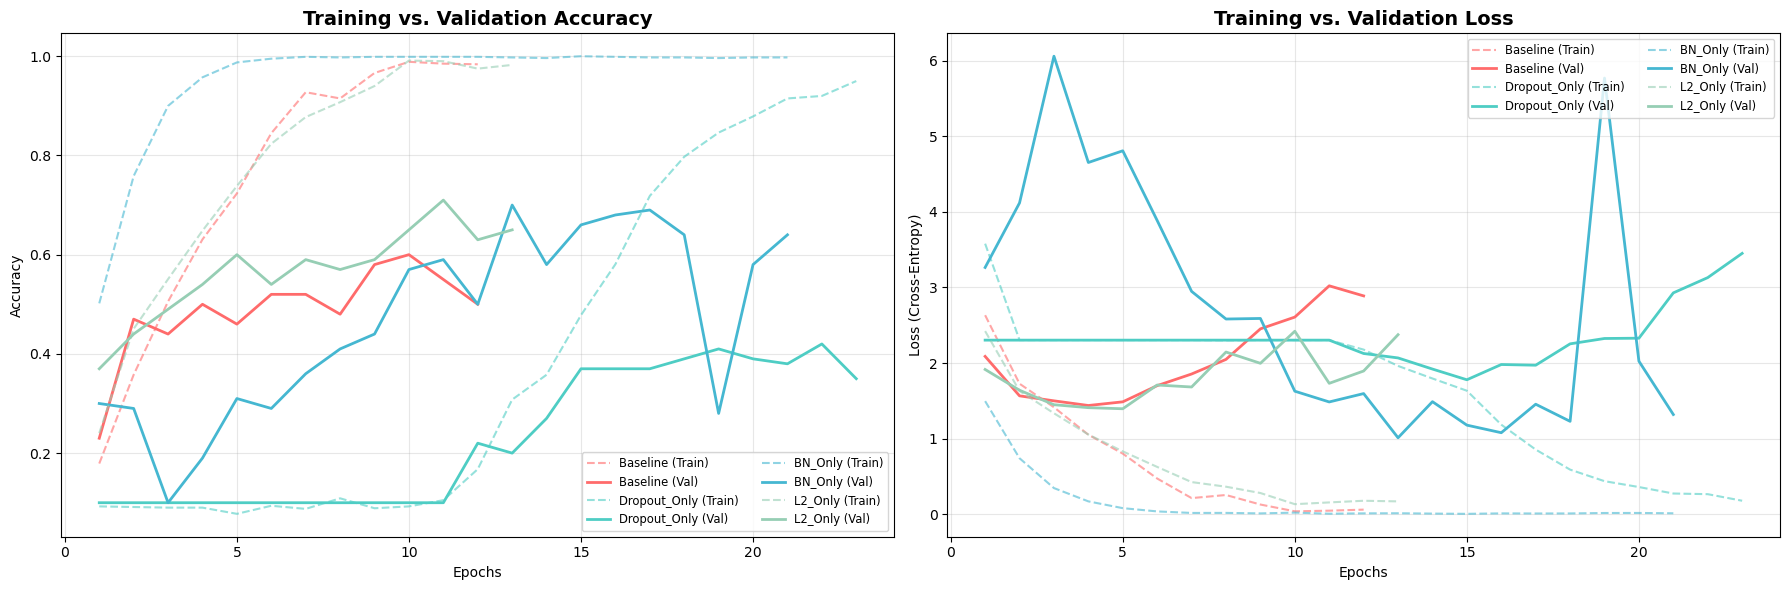

In [5]:
# extracting best validation loss from the history objects already in memory
for name, history in histories.items():
    # We take the minimum because lower loss is better
    best_val_loss = min(history.history['val_loss'])
    results[name]['best_val_loss'] = best_val_loss

# re-create the summary table
summary_df = pd.DataFrame(results).T
summary_df['Gen_Ratio'] = summary_df['test_accuracy'] / summary_df['train_accuracy']

# re-order and clean up
summary_table = summary_df[['train_accuracy', 'val_accuracy', 'test_accuracy', 
                            'overfitting_gap', 'Gen_Ratio', 'best_val_loss']]

summary_table.columns = ['Train Acc', 'Val Acc', 'Test Acc', 'Gap', 'Gen. Ratio', 'Best Val Loss']

print("---Updated metrics ---")
print(summary_table.to_string(formatters={
    'Train Acc': '{:,.4f}'.format, 'Val Acc': '{:,.4f}'.format, 
    'Test Acc': '{:,.4f}'.format, 'Gap': '{:,.4f}'.format, 
    'Gen. Ratio': '{:,.4f}'.format, 'Best Val Loss': '{:,.4f}'.format
}))

def plot_learning_curves(histories):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    colors = {'Baseline': '#FF6B6B', 'Dropout_Only': '#4ECDC4', 
              'BN_Only': '#45B7D1', 'L2_Only': '#96CEB4'}

    for name, history in histories.items():
        color = colors.get(name, None)
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        # Plot Accuracy
        ax1.plot(epochs, history.history['accuracy'], label=f'{name} (Train)', 
                 linestyle='--', alpha=0.6, color=color)
        ax1.plot(epochs, history.history['val_accuracy'], label=f'{name} (Val)', 
                 linewidth=2, color=color)
        
        # Plot Loss
        ax2.plot(epochs, history.history['loss'], label=f'{name} (Train)', 
                 linestyle='--', alpha=0.6, color=color)
        ax2.plot(epochs, history.history['val_loss'], label=f'{name} (Val)', 
                 linewidth=2, color=color)

    ax1.set_title('Training vs. Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', fontsize='small', ncol=2)
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Training vs. Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss (Cross-Entropy)')
    ax2.legend(loc='upper right', fontsize='small', ncol=2)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves_comparison.png', dpi=300)
    plt.show()

# Run the plotting function
plot_learning_curves(histories)